# A2C (Advantage Actor Critic)


For ReLAx & Mujoco installation see: https://github.com/nslyubaykin/relax/blob/master/README.md

Useful readings regarding A2C:

    A2C description: https://julien-vitay.net/deeprl/ActorCritic.html#sec:advantage-actor-critic-a2c

!Note: For examining trained actor you may just load trained policies from \trained_models directory. To do that instead of running 'Run Training and Validation loop' cell, just run 'Load Models' cell

!Note: Trained policies, logs and videos are in the main repository of that notebook: https://github.com/nslyubaykin/relax_a2c_example

In [1]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from inspect import getsource
from torch.utils.tensorboard import SummaryWriter

from relax.rl.actors import VPG
from relax.rl.critics import BootstrappedContinuous

from relax.zoo.policies import CategoricalMLP, NormalMLP
from relax.zoo.critics import VMLP

from relax.data.sampling import Sampler

from relax.gym.utils import visualize_actor

/home/nlyubaykin/anaconda3/envs/relax/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Constructing Actor's stochastic policy

A2C is an RL algorithm that utilizes stochastic policy. On practice, that means that policy is a torch.nn.Module that takes a batch of observations with a shape (BATCH_SIZE, \*obs.dim) and outputs:

1) For discrete control case - batch of logits with a shape of (BATCH_SIZE, ACS_DIM), which then is passed to SoftMax function over the actions dimension (-1). Resulting probs parametrize torch.distributions.Categorical distribution

2) For continuous control case - batch of actions' means with a shape of (BATCH_SIZE, ACS_DIM). After that these means together with state independent actions log(stds) (implemented as trainable torch.nn.Parameter) parameterize torch.distributions.MultivariateNormal distribution

To sum up, A2C policy is a network that takes a batch of observations with a shape (BATCH_SIZE, \*obs.dim) and outputs a parameterized torch.distributions.Distribution object

Therefore any custom user defined networks meeting this requirements should work well with A2C actor

So let's examine the default implementation of stochastic policy offered by ReLAx:

In [2]:
# Discrete Case
print(getsource(CategoricalMLP))

class CategoricalMLP(nn.Module):
    
    def __init__(self, obs_dim, acs_dim, nlayers,
                 nunits, activation=nn.Tanh(),
                 out_activation=nn.Identity()):
        
        super(CategoricalMLP, self).__init__()
        
        layers = []
        in_size = obs_dim
        for _ in range(nlayers):
            layers.append(nn.Linear(in_size, nunits))
            layers.append(activation)
            in_size = nunits
        layers.append(nn.Linear(in_size, acs_dim))
        layers.append(out_activation)
        
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        
        logits = self.layers(x)
        y = Categorical(probs=F.softmax(logits, dim=-1))
        
        return y



In [3]:
# Continuous Case
print(getsource(NormalMLP))

class NormalMLP(nn.Module):
    
    def __init__(self, obs_dim, acs_dim, nlayers,
                 nunits, activation=nn.Tanh(),
                 out_activation=nn.Identity(),
                 acs_scale=1, acs_bias=0,
                 init_log_std=0.0):
        
        super(NormalMLP, self).__init__()
        
        layers = []
        in_size = obs_dim
        for _ in range(nlayers):
            layers.append(nn.Linear(in_size, nunits))
            layers.append(activation)
            in_size = nunits
        
        self.layers = nn.Sequential(*layers)
        
        self.mean_layer = nn.Sequential(
            nn.Linear(nunits, acs_dim),
            out_activation
        )
        
        self.log_stds = nn.Parameter(
            torch.ones(acs_dim) * init_log_std
        )
        
        self.acs_scale = acs_scale
        self.acs_bias = acs_bias

    def forward(self, x):
        
        x_seq = self.layers(x)
        means = self.mean_layer(x_seq)
        means = m

# Constructing Bootstrapped-Continuous Critic

A2C is closely related to VPG in terms of architecture, the only difference is the way critic is updated and advantages are estimated. While Baseline critic subtracts aproximated Value function from reward-to-go Monte-Carlo Q-function estimation to caclucate an Advantage, Bootstrapped-Continuous critic uses a bootstrapped estimate which can be expressed as: 

$ \hat{A}^{\pi}(a_{t}, s_{t}) \approx r(a_{t}, s_{t}) + \gamma*\hat{V}^{\pi}_{\phi}(S_{t+1}) - \hat{V}^{\pi}_{\phi}(S_{t})$

Actor's policy is trained in a pair with Bootstrapped-Continuous critic network which approximates value function. Critic network takes a batch of observations with a shape (BATCH_SIZE, \*obs.dim) and outputs a batch of Value function estimations with a shape of (BATCH_SIZE, 1)

Therefore any custom user defined networks meeting this requirements should work well with BootstrappedContinuous critic

So let's examine the default implementation of V-Network Critic offered by ReLAx:

In [4]:
print(getsource(VMLP))

class VMLP(nn.Module):
    
    def __init__(self, obs_dim, nlayers,
                 nunits, activation=nn.Tanh(),
                 out_activation=nn.Identity()):
        
        super(VMLP, self).__init__()
        
        layers = []
        in_size = obs_dim
        for _ in range(nlayers):
            layers.append(nn.Linear(in_size, nunits))
            layers.append(activation)
            in_size = nunits
        layers.append(nn.Linear(in_size, 1))
        layers.append(out_activation)
        
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)



# Create training and eval environments

In [27]:
env_name = 'LunarLander-v2'
env = gym.make(env_name)
eval_env = gym.make(env_name)
eval_env.seed(np.random.randint(100))

[1]

In [28]:
env.action_space

Discrete(4)

In [29]:
env.observation_space

Box(8,)

In [30]:
acs_dim = 4
obs_dim = 8

# Define VPG actor:

!Note: A2C uses the same actor class as VPG

In [31]:
actor = VPG(
    policy_net=CategoricalMLP(obs_dim, acs_dim, 
                              nunits=64, nlayers=2),
    device=torch.device('cuda'),
    learning_rate=0.01,
    gamma=0.99
)

# Define BootstrappedContinuous critic:

In [32]:
critic = BootstrappedContinuous(
    critic_net=VMLP(obs_dim, nlayers=2, nunits=64),
    device=torch.device('cuda'),
    learning_rate=0.01,
    gamma=0.99,
    n_target_updates=1, 
    n_steps_per_update=100,
)

# Provide actor with critic:

In [33]:
actor.set_critic(critic)

# Wrap envs into Sampler:

In [34]:
sampler = Sampler(env=env)
eval_sampler = Sampler(env=eval_env)

# Visualize untrained actor

In [13]:
visualize_actor(env=eval_env, actor=actor, nsteps=200, train_sampling=False)

Simulation done, total reward: -223.47360955979602
Loading video...


# Run Training and Validation loop:

In [35]:
n_steps = 100
logdir = '/home/nlyubaykin/Desktop/RelaxExamples/A2C/tensorboard_logs'
run_name = 'a2c_lander'
logger = SummaryWriter(log_dir=f'{logdir}/{run_name}')
all_logs = []

for step in tqdm(range(n_steps)): # 
    
    # sample training batch
    train_batch = sampler.sample(actor=actor,
                                 n_transitions=40000,
                                 max_path_length=None, 
                                 reset_when_not_done=False,
                                 train_sampling=True)
    
    # update critic
    critic_logs = critic.update(train_batch)
        
    # update actor
    actor_logs = actor.update(train_batch)
     
    # evaluating the policy
    eval_batch = eval_sampler.sample_n_episodes(actor=actor,
                                                n_episodes=5,
                                                max_path_length=None, 
                                                train_sampling=False)
    # Logging
    train_logs = train_batch.create_logs(prefix='train')
    eval_logs = eval_batch.create_logs(prefix='eval')
    
    logs = {**critic_logs,
            **actor_logs,
            **train_logs,
            **eval_logs}
    all_logs.append(logs)

    for key, value in logs.items():
        logger.add_scalar(key, value, step)
    
logger.flush()

100%|██████████| 100/100 [1:36:23<00:00, 57.83s/it] 


In [40]:
%load_ext tensorboard
%tensorboard --logdir /home/nlyubaykin/Desktop/RelaxExamples/A2C/tensorboard_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6546), started 2 days, 3:11:01 ago. (Use '!kill 6546' to kill it.)

# Plot learning curve

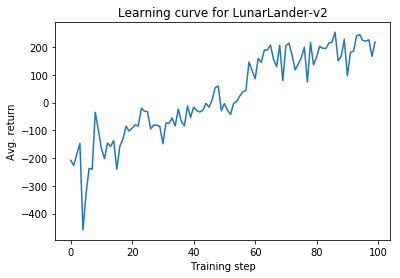

In [36]:
eval_score = [l['avg_return/eval'] for l in all_logs]
plt.plot(eval_score)
plt.title(f'Learning curve for {env_name}')
plt.xlabel('Training step')
plt.ylabel('Avg. return')
plt.show()

# Visualize trained actor

In [38]:
visualize_actor(env=eval_env, actor=actor, nsteps=300, train_sampling=False)

Simulation done, total reward: 118.843115872755
Loading video...


# Save Models

In [39]:
actor.save_checkpoint('trained_models', 'vpg_actor')
critic.save_checkpoint('trained_models', 'bootstrappedcontinuous_critic')

Saved checkpoints for VPG...
models_state_dict global_step n_updates optimizer scheduler
Saved checkpoints for BootstrappedContinuous...
models_state_dict global_step n_updates optimizer scheduler


/home/nlyubaykin/anaconda3/envs/relax/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


# Load Models

In [ ]:
actor.load_checkpoint('trained_models', 'vpg_actor')
critic.load_checkpoint('trained_models', 'bootstrappedcontinuous_critic')